# Long Short Term Memory (RNN) methods 

In [1]:
# Import libraries
import pandas as pd
from IPython.display import display
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

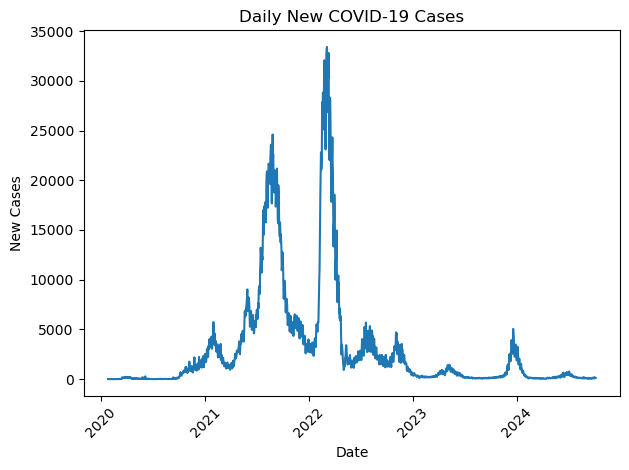

In [2]:
NUM_OF_PREV_ITEMS =5 #how many previous that will be used to connect/ depends 
numpy.random.seed(1) # same random number will be generated if put 1 
# Load the dataset
df = pd.read_csv('cases_state.csv', usecols=['date', 'state', 'cases_new'])

# Convert 'date' column to datetime format if it's not already
df['date'] = pd.to_datetime(df['date'],  format='%Y-%m-%d')

# Aggregate data by date if you want to plot the total new cases across all states per day
df_grouped = df.groupby('date')['cases_new'].sum().reset_index()

# Plot the total new cases per day
plt.plot(df_grouped['date'], df_grouped['cases_new'])
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.title('Daily New COVID-19 Cases')
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to avoid overlap
plt.show()

### Data Preprocessing 
#### Adding and sorting the data based on date order, scaling the numerical values in suitable range (0 and 1), structuring data by creating sequences past values to be input and target being next value in sequences, and split data into 70% training set and 30% test set.

In [9]:
# Display the aggregated data
display(df_grouped.head(10))

# Get the total number of rows
total_rows = df_grouped.shape[0]
print("Total number of rows:", total_rows)

# sort by date order
df_grouped = df_grouped.sort_values(by='date')

#used to scale data into between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
#drop date columns because it doesnt need to be scaled, just cases_new column only
scaled_data = scaler.fit_transform(df_grouped.drop(['date'], axis=1))

# Scaled data (Numpy array) is converted back into dataframe 
df_grouped_scaled = pd.DataFrame(scaled_data, columns=df_grouped.columns[1:])

#original 'date' is added back into new data frame 
df_grouped_scaled['date'] = df_grouped['date'].values

#convert data into suitable format for LSTM, sequence_length is for how many previous step model used to make predictions 
def reconstruct_data(data, sequence_length=30):
    X = [] #array of past sequence until current 
    y = [] #values of target variable [cases_new] at current value 
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, :])
        y.append(data[i, 0])  
    return np.array(X), np.array(y)

# Assuming 'cases_new' is the first column after the date column, scaled data is converted into Numpy array for easy manipulation 
data_for_lstm = df_grouped_scaled.drop(['date'], axis=1).values
# to prepare data for LSTM model , x is the input and y is the output 
X, y = reconstruct_data(data_for_lstm)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False) #shuffle is for data remains in chronological order



,date,cases_new
0,2020-01-25,4
1,2020-01-26,0
2,2020-01-27,0
3,2020-01-28,0
4,2020-01-29,3
5,2020-01-30,1
6,2020-01-31,0
7,2020-02-01,0
8,2020-02-02,0
9,2020-02-03,0


Total number of rows: 1716


### LSTM Algorithms 
#### create the model architecture, train the data, evaluate test dataset , predicts using model and visualize the results, anaylze the results using MSE (Mean square Error) and MAE (Mean Absolute Error)
##### Notes
Adding more layers could make it learn complex patterns, however if it too much, it could lead to overfitting,longer time training
Adding a large value of dropout could lead to underfitting, because it fails to learn important patterns 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 30, 50)            10400     
                                                                 
 dropout_9 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 30, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 30, 50)            20200     
                                                                 
 dropout_11 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_12 (LSTM)              (None, 50)               

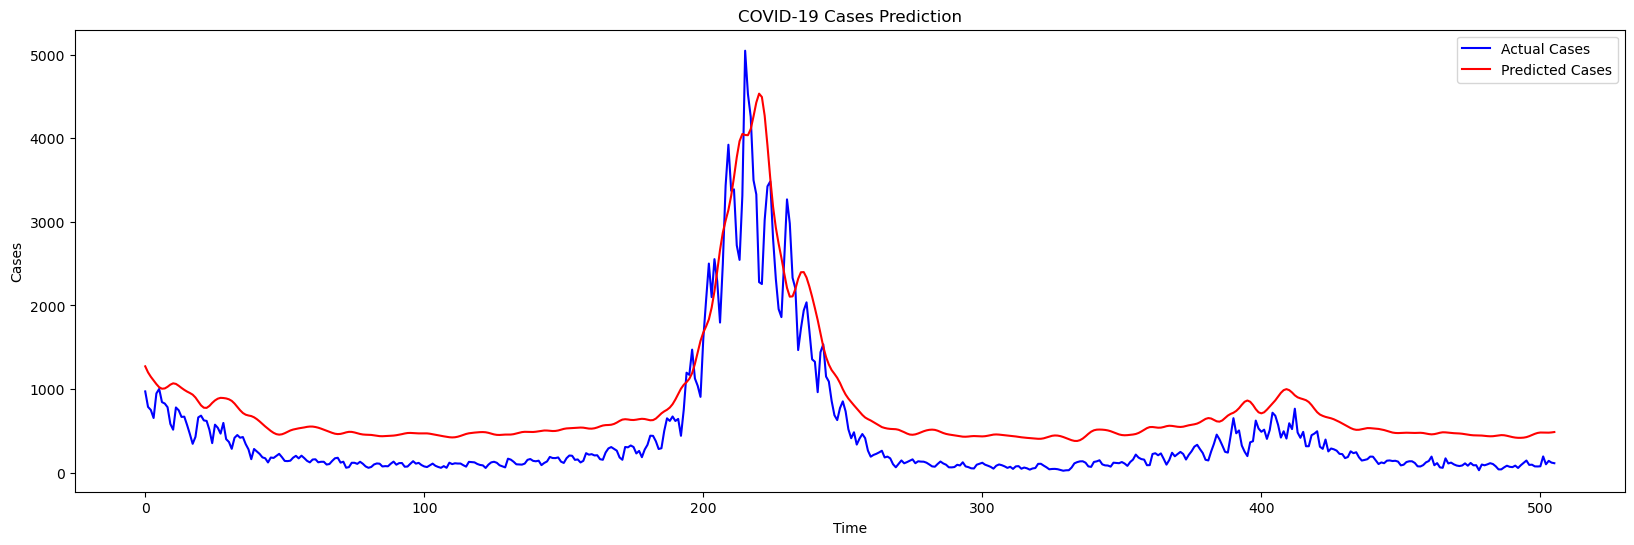

Mean Squared Error: 174907.17315591424
Mean Absolute Error: 375.80993953900844


In [10]:
# Define the LSTM model
model = Sequential()

#have 2 hidden layers added in RNN
#units for 50 neuron in the layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) #add the first layer 
model.add(Dropout(0.2))  # Helps prevent overfitting add neuron in hidden layer 
model.add(LSTM(units=50, return_sequences=True)) # add second LSTM layer, true because needs for the next input hidden layer
model.add(Dropout(0.2)) # 20% of neurons are randomly ignored during each training iteration
model.add(LSTM(units=50, return_sequences=False)) # add third LSTM layer, it is false because dy last hidden layer 
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer, single unit because wants to make prediction for single values 

# Compile the model, loss function: to calculate the difference between predicts and real using adam optimizer
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model architecture, print: numbers layer, output shape, total numbers parameter trained
model.summary()

# fit the train data into model, 
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)
#epochs for how many times the model will see entire dataset, batch_size for how many samples it processes before updating weights. 

# Evaluate the model on test data
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values (to convert back to original scale)
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))


# plot the graph for the 
plt.figure(figsize=(20, 6))
plt.plot(y_test_original, color='blue', label='Actual Cases')
plt.plot(y_pred_original, color='red', label='Predicted Cases')
plt.title('COVID-19 Cases Prediction')
plt.xlabel('Time')
plt.ylabel('Cases')
plt.legend()
plt.show()

# calculate to quantify model's performance and print the results 
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


## Data Preprocessing 

In [11]:
# # Select relevant columns
# #copy is used to ensure cases is a completely new DataFrame, not a view of another, which eliminates the warning.
# cases = df[['date', 'cases_new']].copy()
# # Ensure 'date' is properly set to datetime type
# cases['date'] = pd.to_datetime(cases['date'])
# # Sort by date to ensure chronological order
# cases = cases.sort_values(by='date')
# 
# #Scale 'cases_new' only
# scaler = MinMaxScaler()
# #calculate and transforms the data based on the min and max values , so the values will always be between 0 and 1
# cases['cases_new'] = scaler.fit_transform(cases['cases_new'].values.reshape(-1, 1)) 
# #print (cases)
# 
# # Drop 'date' if you're not using it directly as a feature
# cases = cases[['cases_new']]
# 
# #split data into training dataset and test dataset (70% training, 30% test)
# train, test = cases [0:int(len(cases)*0.7)], cases[int(len(cases)*0.7):]
# 
# # Drop 'date' if you're not using it directly as a feature
# cases = cases[['cases_new']]
# 
# #convert an array of values into matrix of features 
# #that are the previous time series values in the past 
# def reconstruct_data (cases, n=1):
#     x,y = [], []
#     for i in range(len(cases) - n - 1):
#         a = cases.iloc[i:(i + n), 0]  # Use .iloc for proper indexing
#         x.append(a)
#         y.append(cases.iloc[i + n, 0])
#     return np.array(x), np.array(y)
# 
# #create training data and test data matrix 
# train_x, test_x = reconstruct_data(train, n=NUM_OF_PREV_ITEMS)
# train_y, test_y = reconstruct_data(test, n=NUM_OF_PREV_ITEMS)
# 
# print(train_x)
# print(train_y)




[[0.00034211 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.00316456 0.0065857  0.00513171 0.0047896  0.00316456]
 [0.0065857  0.00513171 0.0047896  0.00316456 0.00615806]
 [0.00513171 0.0047896  0.00316456 0.00615806 0.0005987 ]]
[[4.61854259e-03 3.32706124e-02 4.70407116e-03 7.78309956e-03
  2.05268560e-03]
 [3.32706124e-02 4.70407116e-03 7.78309956e-03 2.05268560e-03
  8.46732809e-03]
 [4.70407116e-03 7.78309956e-03 2.05268560e-03 8.46732809e-03
  2.73691413e-03]
 ...
 [1.36845706e-03 2.56585700e-04 5.13171399e-04 8.55285665e-05
  2.56585700e-04]
 [2.56585700e-04 5.13171399e-04 8.55285665e-05 2.56585700e-04
  5.98699966e-04]
 [5.13171399e-04 8.55285665e-05 2.56585700e-04 5.98699966e-04
  0.00000000e+00]]
